In [1]:
import src.layoutparser.models.detectron2.layoutmodel as lp
import src.layoutparser.elements.layout as lay
import src.layoutparser.elements.layout_elements as le
import src.layoutparser.visualization as viz
import src.layoutparser.ocr.tesseract_agent as tes

from PIL import Image, ImageDraw
import numpy as np

In [14]:
model = lp.Detectron2LayoutModel(
            config_path = './binary_model/config.yaml',
            model_path  = './binary_model/model_final.pth',
            label_map   = {1:"Paragraph", 2:"Other"}, # In model`label_map`
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
        )

In [15]:
ocr_agent = tes.TesseractAgent(languages='eng') 

In [16]:
im = Image.open('./00000691.tif')

layout = model.detect(im)

masks = model.masks(im)

### Union
All intersections above a cetrain <u>threshold</u> are merged.

In [6]:
def intersection_over_union(a,b):
    x1 = max(a.block.x_1, b.block.x_1)
    y1 = max(a.block.y_1, b.block.y_1)
    x2 = min(a.block.x_2, b.block.x_2)
    y2 = min(a.block.y_2, b.block.y_2)
    if (y2-y1) <= 0 or (x2-x1) <= 0:
        return 0

    intersection = (x2-x1)*(y2-y1)

    areaA = (a.block.x_2 - a.block.x_1) * (a.block.y_2 - a.block.y_1)
    areaB = (b.block.x_2 - b.block.x_1) * (b.block.y_2 - b.block.y_1)

    iou = intersection / (areaA + areaB - intersection)

    return iou

def unions(blocks, threshold=500):
    unions = []
    disappear = []
    count = 1
    while count != 0:
        count = 0
        for i in range(len(blocks)):
            if i in disappear:
                continue
            not_intersect = True
            for j in range(i+1, len(blocks)):
                if intersection_over_union(blocks[i], blocks[j]) > 0 and abs(blocks[i].block.x_1-blocks[j].block.x_1) < threshold:
                    unions.append(blocks[i].union(blocks[j]))
                    disappear.append(j)
                    not_intersect = False
                    count += 1
            if not_intersect:
                unions.append(blocks[i])
        blocks = unions
        unions = []
        disappear = []

    return lay.Layout(blocks)

### Sort
Sort the reading order from left to right and from top to bottom.

In [7]:
def sorting(text_blocks, image, threshold=500):
    arr_im = np.asarray(im)

    height, width = arr_im.shape[:2]

    text_blocks.sort(key = lambda b:b.coordinates[0], inplace=True)

    intervals = []

    for i in range(len(text_blocks)):
        x_1 = text_blocks[i].block.x_1
        if i == 0:
            intervals.append(x_1)
            curr_x = x_1
        else:
            if (x_1 - curr_x) >= threshold:
                intervals.append(x_1)
                curr_x = x_1  

    blocks = []

    for i in range(len(intervals)):
        if i == len(intervals) - 1:
            curr_interval = le.Interval(intervals[i],width, axis='x').put_on_canvas(im)
        else:
            curr_interval = le.Interval(intervals[i], intervals[i+1], axis='x').put_on_canvas(im)
        block = text_blocks.filter_by(curr_interval, center=True)
        block.sort(key = lambda b:b.coordinates[1], inplace=True)
        blocks.append(block)

    bl = blocks[0]
    for i in range(1,len(blocks)):
        bl += blocks[i]

    return lay.Layout([b.set(id = idx) for idx, b in enumerate(bl)])

In [8]:
def left_to_right_overlap(text_blocks):
    for i in range(len(text_blocks)):
        for j in range(i+1, len(text_blocks)):
            if intersection_over_union(text_blocks[i], text_blocks[j]) > 0:
                right_rec_percentage = (text_blocks[i].block.x_2-text_blocks[j].block.x_1) / (text_blocks[i].block.x_2-text_blocks[i].block.x_1)
                left_rec_percentage  = (text_blocks[i].block.x_2-text_blocks[j].block.x_1) / (text_blocks[j].block.x_2-text_blocks[j].block.x_1)
                if right_rec_percentage >= left_rec_percentage:
                    text_blocks[j].block.x_1 = text_blocks[i].block.x_2
                else:
                    text_blocks[i].block.x_2 = text_blocks[j].block.x_1
    
    return text_blocks


In [9]:
text_blocks = lay.Layout([b for b in layout if b.type=='Paragraph'])
figure_blocks = lay.Layout([b for b in layout if b.type=='Other'])

text_blocks = lay.Layout([b for b in text_blocks if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

text_blocks = lay.Layout([i.pad(left=15, right=15, top=15, bottom=15) for i in text_blocks])

text_blocks = unions(text_blocks)

text_blocks = sorting(text_blocks, im)

text_blocks = left_to_right_overlap(text_blocks)

In [10]:
draw = ImageDraw.Draw(im)

for i in masks:
    if i[0] == 2:
        coords = np.nonzero(i[1])
        coords = [(coords[1][i],coords[0][i]) for i in range(len(coords[0]))]
        draw.polygon(coords)

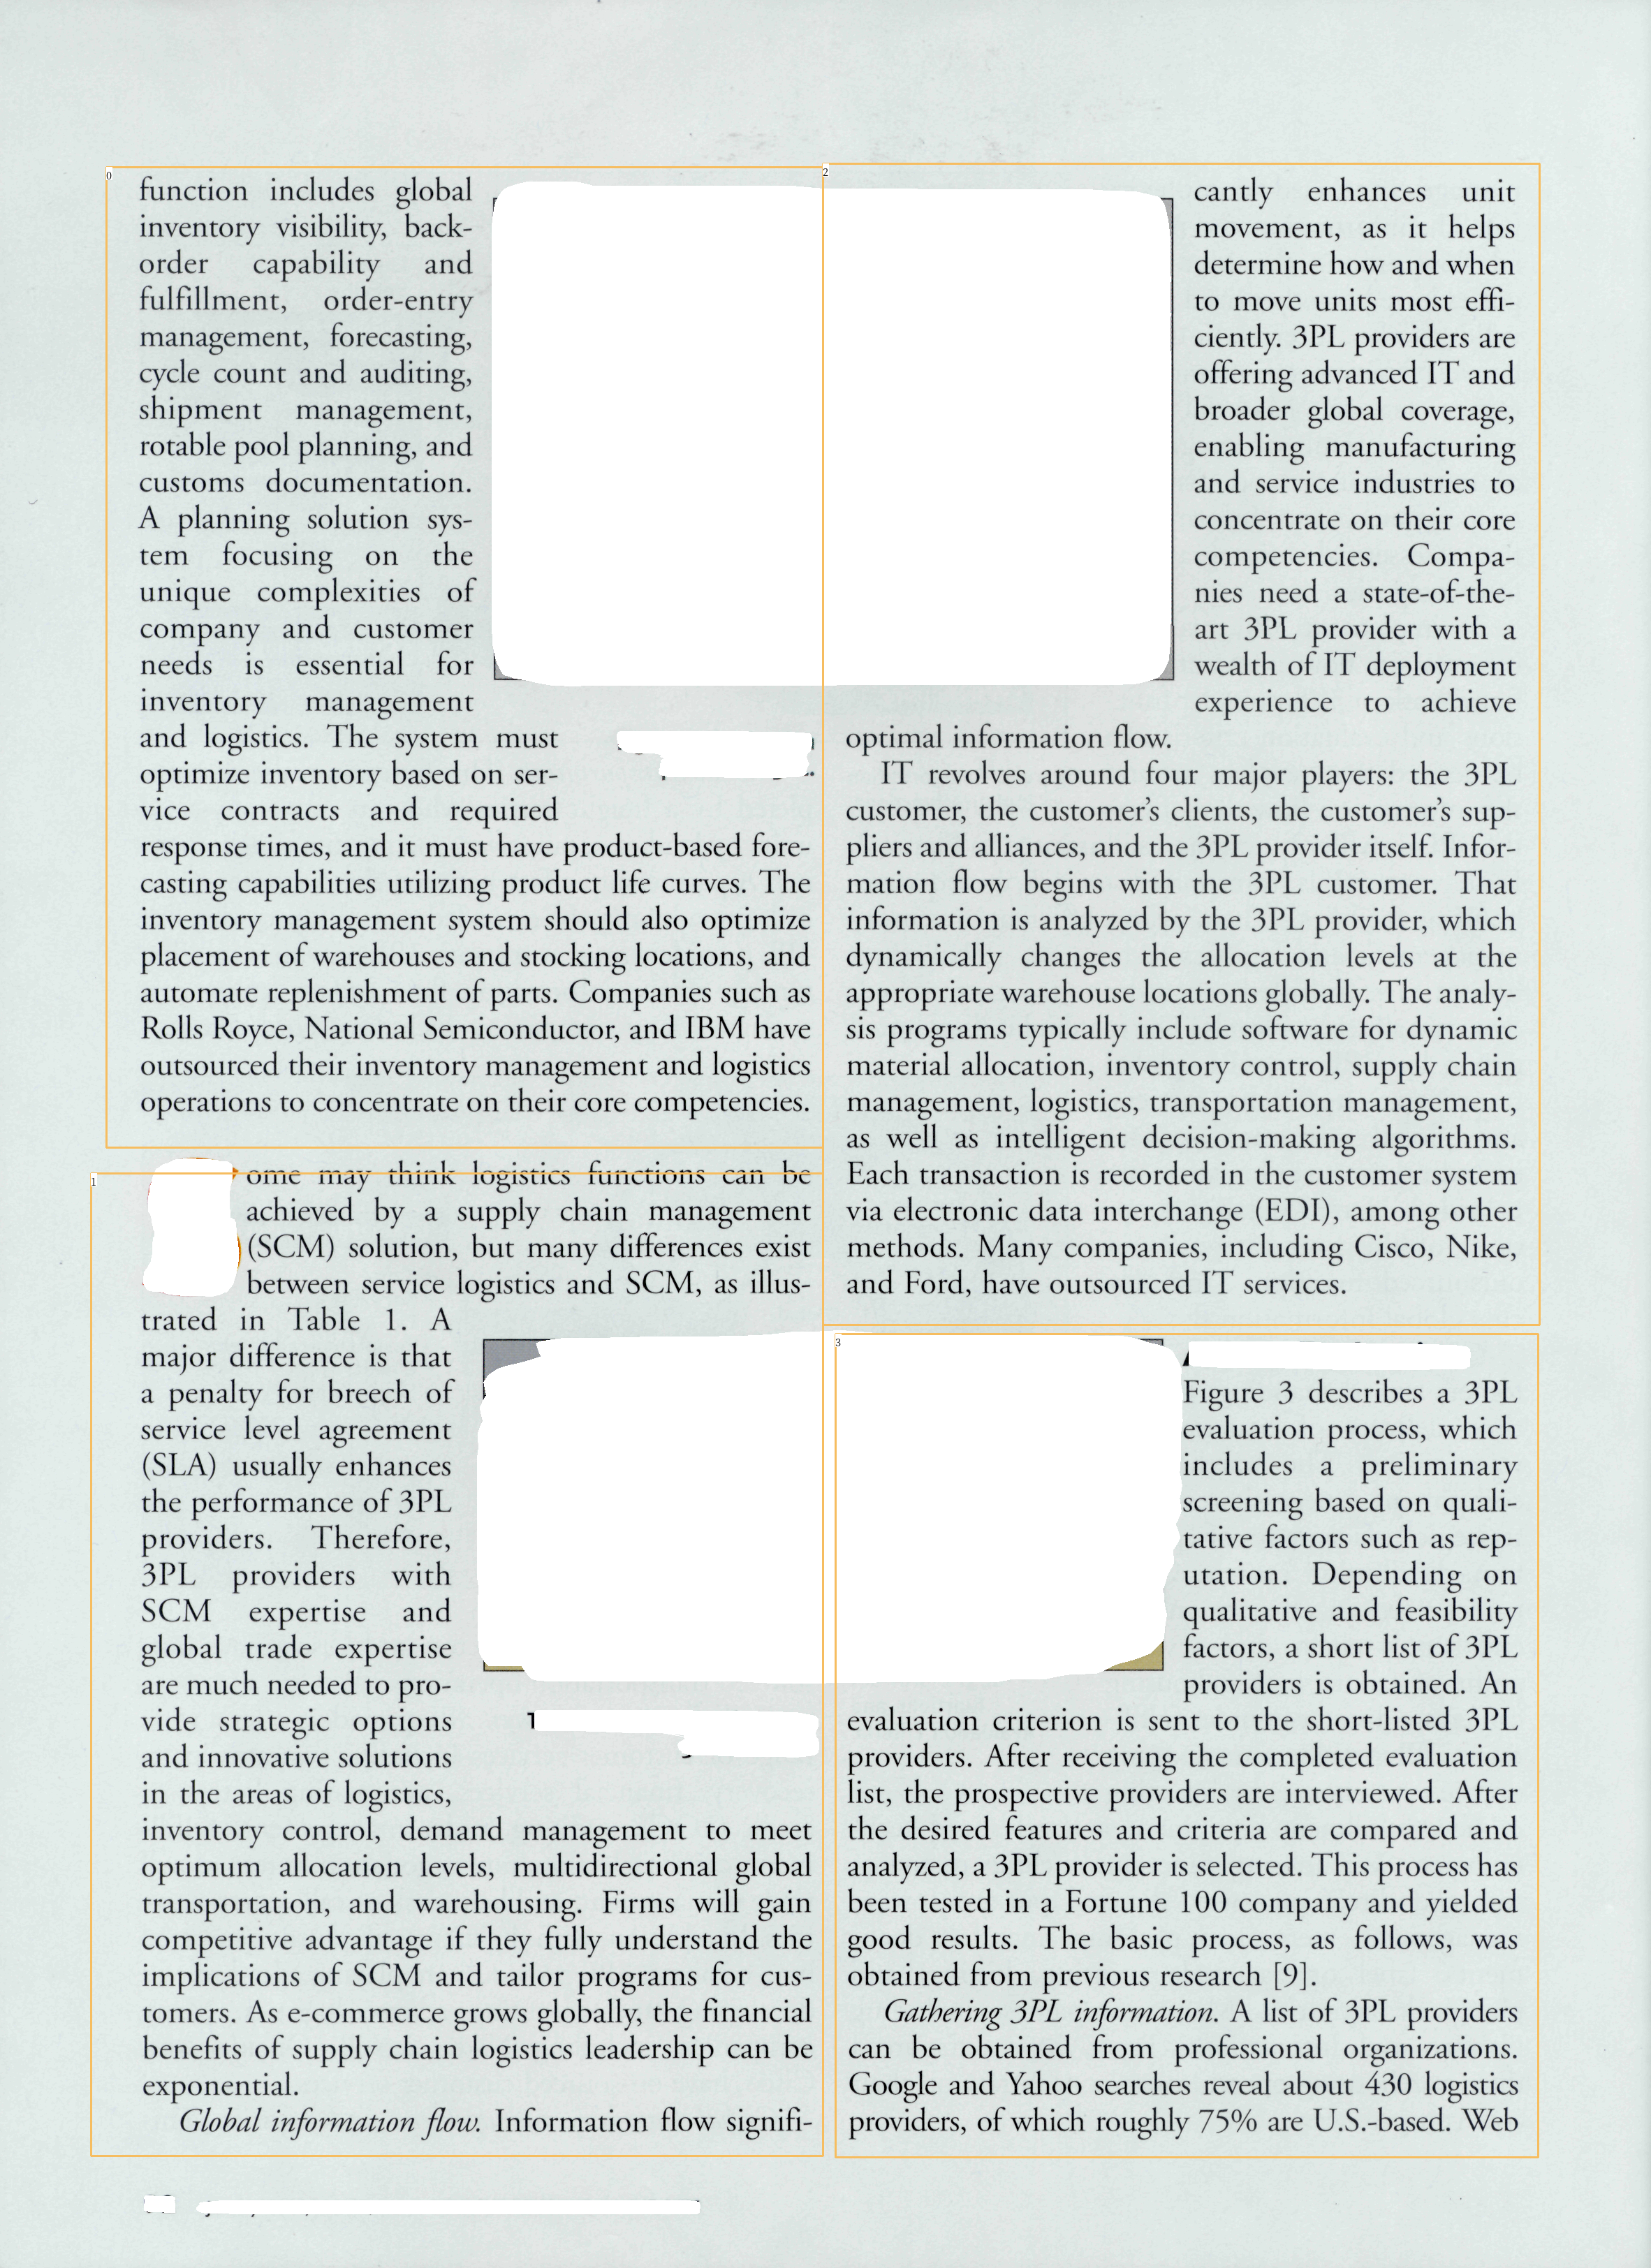

In [11]:
viz.draw_box(im, text_blocks,
            box_width=3, 
            show_element_id=True)

In [14]:
arr_im = np.asarray(im)

for block in unions(text_blocks):
    segment_image = (block.crop_image(arr_im))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)


for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

function includes global ,
inventory visibility, back-
order capability and
fulfillment, order-entry
management, forecasting,
cycle count and auditing,
shipment management,
rotable pool planning, and
customs documentation.

A planning solution sys-

tem focusing on the
unique complexities of
company and customer
needs is essential for \_
inventory management

and logistics. The system must
optimize inventory based on ser- . math
vice contracts and required

response times, and it must have product-based fore-
casting capabilities utilizing product life curves. The
inventory management system should also optimize
placement of warehouses and stocking locations, and
automate replenishment of parts. Companies such as
Rolls Royce, National Semiconductor, and IBM have
outsourced their inventory management and logistics
operations to concentrate on their core competencies.

---
POLICE aniay Ul Mp tetive AULICUIUTIS Cdll UO
achieved by a supply chain management
|(SCM) solution, but many diffe